In [ ]:
# Author: Haocheng Xia
# Date: 2020/1/4
# Computer Vision 光荣题

In [5]:
import sklearn.datasets
from sklearn.datasets import fetch_openml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sklearn.datasets.fetch_*?

In [6]:
mnist = fetch_openml("mnist_784")

In [8]:
x = mnist["data"]
y = mnist["target"]

In [9]:
m = len(x)
perm = np.random.permutation(m)
x_train, x_test = x[perm][10000:],x[perm][:10000]
y_train, y_test = y[perm][10000:],y[perm][:10000]

x_train = x_train/255
x_test = x_test/255

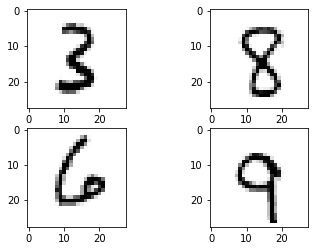

In [10]:
# check content of the dataset
f, ax = plt.subplots(2,2)
ax[0, 0].imshow(x[50000].reshape(28, 28), cmap = 'Greys')
ax[0, 1].imshow(x[50001].reshape(28, 28), cmap = 'Greys')
ax[1, 0].imshow(x[50002].reshape(28, 28), cmap = 'Greys')
ax[1, 1].imshow(x[50003].reshape(28, 28), cmap = 'Greys')


In [11]:
from scipy.ndimage.interpolation import shift

In [12]:
# func: shift pic to enlarge dataset
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dx, dy], cval = 0, mode = 'constant')
    return shifted_image.reshape([-1])

In [13]:
# image & label 
x_train_shifted = []
y_train_augmented = []

for dx, dy in ((1,0),(-1,0),(0,1),(0,-1)):
    for image, label in zip(x_train, y_train):
        x_train_shifted.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [14]:
x_train_shifted = np.array(x_train_shifted)
y_train_augmented = np.array(y_train_augmented)

In [15]:
x_train_shifted.shape, y_train_augmented.shape

((240000, 784), (240000,))

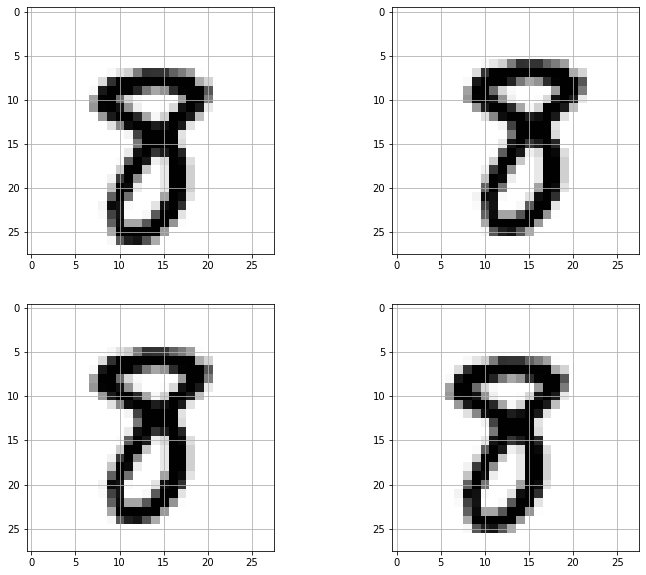

In [16]:
# show the img shifted in 4 different directions
f, ax = plt.subplots(2,2,figsize = (12, 10))
ax[0,0].imshow(x_train_shifted[1].reshape(28,28), cmap = 'Greys')
ax[1,0].imshow(x_train_shifted[60001].reshape(28,28), cmap = 'Greys')
ax[0,1].imshow(x_train_shifted[120001].reshape(28,28), cmap = 'Greys')
ax[1,1].imshow(x_train_shifted[180001].reshape(28,28), cmap = 'Greys')
ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()

In [17]:
# check y_train_augmented
y_train_augmented[1],y_train_augmented[60001],y_train_augmented[120001],y_train_augmented[180001]

('8', '8', '8', '8')

In [18]:
import cv2

In [19]:
cv2.__version__

'4.1.2'

In [20]:
# get the flipped img to enlarge the dataset
def horizontal_flip(images):
    flipped_images = []
    for img in images:
        flipped_img = cv2.flip(img, flipCode = 1)
        flipped_images.append(flipped_img)
    return (flipped_images)

In [21]:
flipped_imgs = horizontal_flip(x_train.reshape(-1, 28, 28))

In [22]:
flipped_imgs = np.array(flipped_imgs)
flipped_lables = np.array(y_train[:])

In [23]:
flipped_imgs = flipped_imgs.reshape(-1, 28, 28)
flipped_imgs.shape, flipped_lables.shape

((60000, 28, 28), (60000,))

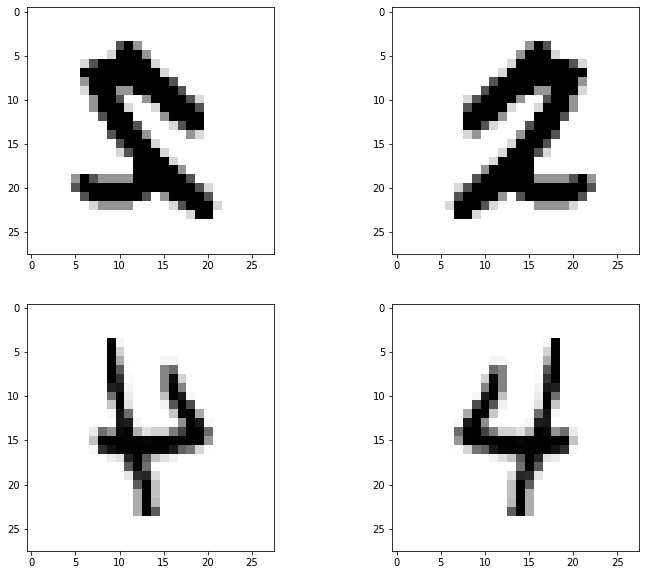

In [24]:
# check the flipped effect
f, ax = plt.subplots(2,2,figsize = (12, 10))
ax[0,0].imshow(flipped_imgs[100].reshape(28,28), cmap = 'Greys')
ax[0,1].imshow(x_train[100].reshape(28,28), cmap = 'Greys')
ax[1,0].imshow(flipped_imgs[200].reshape(28,28), cmap = 'Greys')
ax[1,1].imshow(x_train[200].reshape(28,28), cmap = 'Greys')

In [25]:
flipped_lables[100], flipped_lables[200]

('2', '4')

In [26]:
# assistant function
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x)//batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        x_batch, y_batch = x[batch_idx], y[batch_idx]
        yield x_batch, y_batch

In [27]:
# begin to create network
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

In [28]:
with tf.name_scope('placeholders'):  
    x = tf.compat.v1.placeholder(np.float32, shape = [None, 28, 28], name = 'x')
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1], name = 'x_reshaped')
    y = tf.compat.v1.placeholder(np.int32, shape = None, name = 'y')

In [29]:
with tf.name_scope('conv'):
    # conv layer
    conv1 = tf.keras.layers.Conv2D(12, [3,3], strides = 1, padding = 'SAME', name = 'conv1')
    tmpRes = conv1(x_reshaped)
    pool1 = tf.keras.layers.MaxPool2D([3,3], strides = 2, name = 'pool1') # [3,3] 
    tmpRes = pool1(tmpRes)
    conv2 = tf.keras.layers.Conv2D(16, [3,3], strides = 1, padding = 'SAME', name = 'conv2')
    tmpRes = conv2(tmpRes)
    pool2 = tf.keras.layers.MaxPool2D([3,3], strides = 2, name = 'pool2')
    tmpRes = pool2(tmpRes)
    pool2_flatten = tf.reshape(tmpRes, shape = (-1, 6*6*16))
    
    fc1 = tf.compat.v1.layers.Dense(256, activation = tf.nn.selu, name = 'fc1')
    tmpRes = fc1(pool2_flatten)
    res_fc1 = tmpRes
    fc2 = tf.keras.layers.Dense(100, activation = tf.nn.selu, name = 'fc2')
    tmpRes = fc2(tmpRes)
    res_fc2 = tmpRes
    logits = tf.keras.layers.Dense(10, activation = tf.nn.selu, name = 'output')
    tmpRes = logits(res_fc2)
    res_logits = tmpRes

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [30]:
# create loss function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = res_logits, labels = y)
    loss = tf.reduce_mean(xentropy)

In [31]:
# train -> minimize the loss
with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
    training_op = optimizer.minimize(loss)

In [32]:
# eval effect
with tf.name_scope('eval'):
    correct = tf.math.in_top_k(y, res_logits, 1, name = 'correct')
    accuracy = tf.reduce_mean(tf.cast(correct, np.float32))

In [33]:
batch_size = 128
out = []

In [34]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    out = []
    for epoch in range(20):
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            x_batch = np.reshape(x_batch, [-1, 28, 28])
            sess.run(training_op, feed_dict = {x:x_batch, y:y_batch})
        if epoch % 1 == 0:
            batch_acc = accuracy.eval(feed_dict = {x:x_batch, y:y_batch})
            x_test = np.reshape(x_test, [-1, 28, 28])
            val_acc = accuracy.eval(feed_dict = {x:x_test, y:y_test})
            print(epoch, "Batch Accuracy = ",batch_acc,"  Validation Accuracy = ",val_acc)
            outputs = sess.run(res_logits, feed_dict = {x:x_test})
            out.append(outputs)

0 Batch Accuracy =  0.9609375   Validation Accuracy =  0.9568
1 Batch Accuracy =  0.96875   Validation Accuracy =  0.9787
2 Batch Accuracy =  1.0   Validation Accuracy =  0.9796
3 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9859
4 Batch Accuracy =  1.0   Validation Accuracy =  0.9839
5 Batch Accuracy =  1.0   Validation Accuracy =  0.9861
6 Batch Accuracy =  1.0   Validation Accuracy =  0.9853
7 Batch Accuracy =  1.0   Validation Accuracy =  0.9871
8 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9855
9 Batch Accuracy =  1.0   Validation Accuracy =  0.9853
10 Batch Accuracy =  1.0   Validation Accuracy =  0.9841
11 Batch Accuracy =  1.0   Validation Accuracy =  0.9866
12 Batch Accuracy =  1.0   Validation Accuracy =  0.9875
13 Batch Accuracy =  1.0   Validation Accuracy =  0.9875
14 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9808
15 Batch Accuracy =  0.984375   Validation Accuracy =  0.9837
16 Batch Accuracy =  1.0   Validation Accuracy =  0.9874
17 Batch

In [35]:
y_hat = np.argmax(outputs, axis = 1)

In [36]:
y_int_test = list(map(int,y_test))

In [37]:
y_hat[:20]

array([5, 0, 4, 0, 3, 7, 0, 1, 2, 4, 1, 3, 8, 2, 7, 5, 2, 0, 5, 3],
      dtype=int64)

In [38]:
y_test[:20]

array(['5', '0', '4', '0', '3', '7', '0', '1', '2', '4', '1', '3', '8',
       '2', '7', '5', '2', '0', '5', '3'], dtype=object)

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
acc_score = accuracy_score(y_int_test, y_hat)
print(acc_score)

0.9886


In [344]:
# use the early shifted and flipped data !!!
tf.compat.v1.reset_default_graph()

In [345]:
with tf.name_scope('placeholders'):
    
    x = tf.compat.v1.placeholder(np.float32, shape = [None, 28, 28], name = 'x')
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1], name = 'x_reshaped')
    y = tf.compat.v1.placeholder(np.int32, shape = None, name = 'y')
    
    bn1_train = tf.compat.v1.placeholder_with_default(True, shape = (None), name = 'bn1_holder')
    bn2_train = tf.compat.v1.placeholder_with_default(True, shape = (None), name = 'bn2_holder')
    
    drop1 = tf.compat.v1.placeholder_with_default(True, shape = (None), name = 'Drop1')
    drop2 = tf.compat.v1.placeholder_with_default(True, shape = (None), name = 'Drop2')

In [346]:
# new with shifted & flipped
with tf.name_scope('conv'):
    # conv layer
    conv1 = tf.keras.layers.Conv2D(12, [3,3], strides = 1, padding = 'SAME', name = 'conv1')
    tmpRes = conv1(x_reshaped)
    pool1 = tf.keras.layers.MaxPool2D([3,3], strides = 2, name = 'pool1') # [3,3] is ?
    tmpRes = pool1(tmpRes)
    res_pool1 = tmpRes
    # momentum & renorm_momentum
    bn1 = tf.compat.v1.layers.batch_normalization(res_pool1, momentum = 0.9, training = bn1_train)
    # tmpRes = bn1(res_pool1, training = bn1_train)
    dropout1 = tf.compat.v1.keras.layers.Dropout(0.5)
    tmpRes = dropout1(bn1, training = drop1)
    
    conv2 = tf.keras.layers.Conv2D(16, [3,3], strides = 1, padding = 'SAME', name = 'conv2')
    tmpRes = conv2(res_pool1) #Attention! use pool1
    pool2 = tf.keras.layers.MaxPool2D([3,3], strides = 2, name = 'pool2')
    tmpRes = pool2(tmpRes)
    res_pool2 = tmpRes
    #bn2 = tf.keras.layers.BatchNormalization(momentum = 0.9)
    bn2 = tf.compat.v1.layers.batch_normalization(res_pool2, momentum = 0.9, training = bn2_train)
    # tmpRes = bn2(tmpRes, training = bn2_train)
    # res_bn2 = tmpRes
    dropout2 = tf.compat.v1.keras.layers.Dropout(0.5)
    tmpRes = dropout2(bn2, training = drop2)
    res_dropout2 = tmpRes
    
    bn2_flatten = tf.reshape(tmpRes, shape = (-1, 6*6*16)) #res_pool2
    
    fc1 = tf.compat.v1.layers.Dense(256, activation = tf.nn.selu, name = 'fc1')
    tmpRes = fc1(bn2_flatten)
    res_fc1 = tmpRes
    fc2 = tf.keras.layers.Dense(100, activation = tf.nn.selu, name = 'fc2')
    tmpRes = fc2(res_fc1)
    res_fc2 = tmpRes
    logits = tf.keras.layers.Dense(10, activation = tf.nn.selu, name = 'output')
    tmpRes = logits(res_fc2)
    res_logits = tmpRes

In [347]:
# create loss function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = res_logits, labels = y)
    loss = tf.reduce_mean(xentropy)

In [348]:
# train -> minimize the loss
with tf.name_scope('train'):
    optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
    training_op = optimizer.minimize(loss)

In [349]:
# eval effect
with tf.name_scope('eval'):
    correct = tf.math.in_top_k(y, res_logits, 1, name = 'correct')
    accuracy = tf.reduce_mean(tf.cast(correct, np.float32))

In [350]:
flipped_imgs_784 = flipped_imgs.reshape((-1,784))

In [351]:
final_x = np.concatenate((x_train,flipped_imgs_784,x_train_shifted),axis=0)

In [352]:
final_x.shape

(360000, 784)

In [353]:
final_y = np.concatenate((y_train,flipped_lables,y_train_augmented),axis=0)

In [354]:
final_y.shape

(360000,)

In [355]:
batch_size = 128
out = []
extra_update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)

In [356]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    out = []
    for epoch in range(20):
        for x_batch, y_batch in shuffle_batch(final_x, final_y, batch_size):
            x_batch = np.reshape(x_batch, [-1, 28, 28])
            sess.run([training_op,extra_update_ops], feed_dict = {x:x_batch, y:y_batch})
        if epoch % 1 == 0:
            batch_acc = accuracy.eval(feed_dict = {x:x_batch, y:y_batch})
            x_test = np.reshape(x_test, [-1, 28, 28])
            val_acc = accuracy.eval(feed_dict = {bn1_train: False, bn2_train: False,
                                                 drop1: False, drop2: False, 
                                                 x:x_test, y:y_test})
            print(epoch, "Batch Accuracy = ",batch_acc,"  Validation Accuracy = ",val_acc)
            outputs = sess.run(res_logits, feed_dict = {bn1_train: False, bn2_train: False,
                                                        drop1: False, drop2: False, 
                                                        x:x_test})
            out.append(outputs)

0 Batch Accuracy =  1.0   Validation Accuracy =  0.9854
1 Batch Accuracy =  0.984375   Validation Accuracy =  0.9905
2 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9907
3 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9915
4 Batch Accuracy =  0.984375   Validation Accuracy =  0.992
5 Batch Accuracy =  0.9609375   Validation Accuracy =  0.9923
6 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9936
7 Batch Accuracy =  0.9921875   Validation Accuracy =  0.992
8 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9941
9 Batch Accuracy =  1.0   Validation Accuracy =  0.9938
10 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9932
11 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9941
12 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9939
13 Batch Accuracy =  0.9921875   Validation Accuracy =  0.9943
14 Batch Accuracy =  1.0   Validation Accuracy =  0.9935
15 Batch Accuracy =  0.9765625   Validation Accuracy =  0.9931
16 Batch Accuracy =  0.9

In [365]:
y_hat = np.argmax(outputs, axis = 1)

In [371]:
y_int_test = list(map(int,y_test))

In [366]:
y_hat[:20]

array([9, 1, 0, 8, 7, 8, 6, 2, 8, 3, 4, 7, 6, 8, 4, 4, 8, 3, 8, 9],
      dtype=int64)

In [367]:
y_test[:20]

array(['9', '1', '0', '8', '7', '8', '6', '6', '8', '3', '4', '7', '6',
       '8', '4', '4', '8', '3', '8', '9'], dtype=object)

In [372]:
y_int_test[:20]

[9, 1, 0, 8, 7, 8, 6, 6, 8, 3, 4, 7, 6, 8, 4, 4, 8, 3, 8, 9]

In [373]:
from sklearn.metrics import accuracy_score

In [374]:
acc_score = accuracy_score(y_int_test, y_hat)
print(acc_score)

0.9928
